In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

sns.set()
np.random.seed(111)

In [2]:
students = pd.read_csv("stud_math.csv")
students.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,...,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,...,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,...,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,...,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,...,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


In [3]:
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

In [4]:
missing = students.isnull().sum().sum() / \
    (students.shape[0] * students.shape[1]) * 100
print(f"Изначально, датасет имеет {round(missing, 2)}% пропусков")

Изначально, датасет имеет 4.77% пропусков


## Используемые функции

In [5]:
def show_distribution_of_quantitative_variable(data, column, bins=None):
    """
        Функция строит график распределения признака и боксплот

        :param data: датафрейм
        :param column: признак, по которому мы строим график
        :param bins: на сколько интервалов разделить график распределения признака
    """
    fig, ax = plt.subplots(nrows=2)

    sns.distplot(data[column], ax=ax[0], bins=bins)
    sns.boxplot(column, data=data, ax=ax[1])
    plt.show()

In [6]:
def show_distribution_of_categorial_variable(data, column):
    """
        Функция строит график количества наблюдений каждого значения признака

        :param data: датафрейм
        :param column: признак, по которому мы строим график
    """
    fig, ax = plt.subplots()
    sns.countplot(column, data=data, ax=ax)
    ax.set_title(f"Распределение признака {column}")
    ax.set_ylim([0, ax.get_ylim()[1] + 20])

    for rect in ax.patches:
        x = rect.xy[0] + rect.get_width()/2
        y = rect.xy[1] + rect.get_height() + 5
        ax.text(x, y, rect.get_height(),
                horizontalalignment='center', fontsize=13)

    plt.show()

In [7]:
def show_boxplot_with_score(data, column):
    """
        Показывает боксплот, используя признак score

        :param data: датафрейм
        :param column: признак, по которому мы строим график
    """
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y="score", data=data, ax=ax)
    ax.set_title(f"Boxplot for {column}", fontsize=15)
    plt.show()

In [8]:
def show_missing_values(data):
    """
        Показывает сколько пропусков в каждой колонке датафрейма

        :param data: датафрейм
        :returns объект Series с данными
    """

    print("Количество пропусков по колонкам:")
    return data.isnull().apply(lambda x: x.sum())

In [9]:
def fillna_with_most_frequent_value_from_another_column(data, target_column, source_column):
    """
        Заполняет столбцы в target_column на основе значений из source_column
        Например:
        target_column - образование
        source_column - работа
        Строка имеет пропуск значения в ячейке образование

        1. Смотрим, какое значение у этой строки в ячейке работа.
        Допустим, это учитель
        2. Далее смотрим, какое самое встречающееся значение в ячейке образование
        у учителей
        * Если значение в ячейке работа отсутствует, то используем самое встречающееся
        значение в ячейке образование среди всех профессий
        3. Заполняем этим значением нашу ячейку образование

        :param data: датафрейм
        :param target_column: название колонки, в которой нужно заполнить пропуски
        :param source_column: название колонки, на основании которой будем заполнять пропуски
        :returns объект Series с заполненными пропусками
    """

    crosstable = pd.crosstab(
        data[source_column], data[target_column], margins=True).iloc[:, :-1]
    values_to_fill = crosstable.apply(lambda x: x.idxmax(), axis=1)

    def fill_values(df):
        source_value = "All" if pd.isnull(df[source_column]) else int(
            df[source_column]) if type(df[source_column]) == float else df[source_column]
        return values_to_fill[source_value] if pd.isnull(df[target_column]) else df

    return data[[target_column, source_column]].apply(fill_values, axis=1)[target_column]

In [10]:
def fillna_proportional_to_other_values(s):
    """
        Заполняет пропуски пропорционально уже имеющимся данным из той же колонки

        :param s: объект Series, в котором необходимо заполнить пропуски
        :returns объект Series с заполненными пропусками
    """
    freqs = s.value_counts(normalize=True)
    return s.apply(lambda x: np.random.choice(freqs.index, p=freqs.values) if pd.isnull(x) else x)

In [11]:
def get_stat_dif(data, column):
    """
        Определяет наличие статистически значимых различий для колонки
        с помощью теста Стьюдента

        :param data: датафрейм
        :param column: признак, для которого определяется различие
    """

    cols = data[column].unique()
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(data.loc[data[column] == comb[0], "score"],
                     data.loc[data[column] == comb[1], "score"]).pvalue \
                <= 0.05/len(combinations_all):
            print('Найдены статистически значимые различия для колонки', column)
            break

## Предварительная обработка

### Численные признаки

In [12]:
quant_cols = ["age", "absences", "score"]
students[quant_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       395 non-null    int64  
 1   absences  383 non-null    float64
 2   score     389 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 9.4 KB


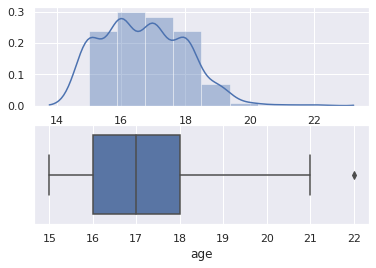

In [13]:
show_distribution_of_quantitative_variable(
    students, "age", bins=students["age"].nunique())

Пропусков в колонке *age* нет и диапазон возрастов соответствует условиям задачи, поэтому оставляем эту колонку как есть

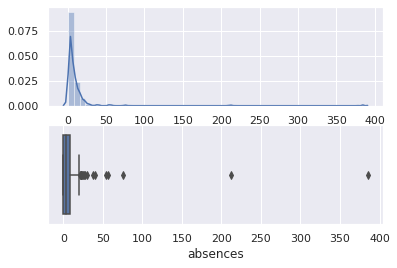

In [14]:
show_distribution_of_quantitative_variable(students, "absences")

В колонке *absences* есть пропуски и есть выбросы. Так как этот признак скорее всего значимый для предсказываемой величины, то удалим из датафрейма учеников с пропусками и выбросами у данного признака

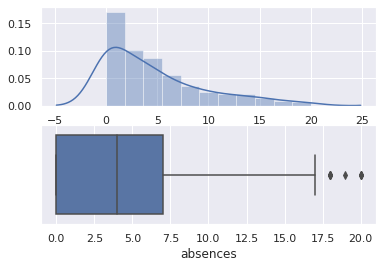

In [15]:
perc25 = students["absences"].quantile(0.25)
perc75 = students["absences"].quantile(0.75)
iqr = perc75 - perc25
students = students[students["absences"].between(0, perc75 + 1.5*iqr)]
show_distribution_of_quantitative_variable(students, "absences")

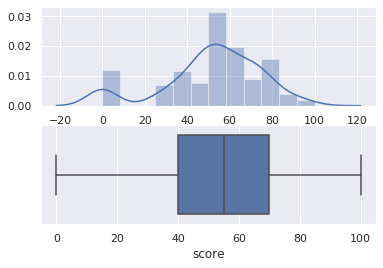

In [16]:
show_distribution_of_quantitative_variable(students, "score")

Удалим также тех учеников, у которых нет оценки по экзамену или она равна нулю, так как они скорее всего не сдавали экзамен

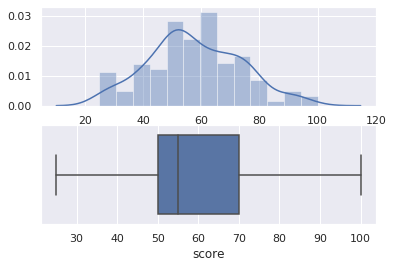

In [17]:
students = students[students["score"] > 0]
show_distribution_of_quantitative_variable(students, "score")

### Категориальные признаки

Для начала удалим признак *studytime, granular*, т.к. он сильно скоррелирован с признаком *studytime*

In [18]:
display(students[["studytime", "studytime, granular"]].corr())
students.drop(["studytime, granular"], axis=1, inplace=True)

,studytime,"studytime, granular"
studytime,1.0,-1.0
"studytime, granular",-1.0,1.0


In [19]:
categ_cols = ["school", "Medu", "Fedu", "Mjob", "Fjob", "reason", "guardian", "failures",
              "traveltime", "studytime", "famrel", "freetime", "goout", "health"]
display(show_missing_values(students[categ_cols]))
print("Количество уникальных значений по колонкам")
students[categ_cols].apply(lambda x: x.nunique())

Количество пропусков по колонкам:


school         0
Medu           2
Fedu          20
Mjob          14
Fjob          30
reason        15
guardian      28
failures      17
traveltime    23
studytime      5
famrel        23
freetime       6
goout          6
health        13
dtype: int64

Количество уникальных значений по колонкам


school        2
Medu          5
Fedu          6
Mjob          5
Fjob          5
reason        4
guardian      3
failures      4
traveltime    4
studytime     4
famrel        6
freetime      5
goout         5
health        5
dtype: int64

Как мы видим, признак *school* не имеет пропусков, мы его пропустим

Также я считаю, что признаки работы и образования взаимосвязаны, поэтому заполним пропуски в одних признаках на основе других

In [20]:
students["Medu"] = fillna_with_most_frequent_value_from_another_column(
    students, "Medu", "Mjob")
students["Fedu"] = fillna_with_most_frequent_value_from_another_column(
    students, "Fedu", "Fjob")
students["Mjob"] = fillna_with_most_frequent_value_from_another_column(
    students, "Mjob", "Medu")
students["Fjob"] = fillna_with_most_frequent_value_from_another_column(
    students, "Fjob", "Fedu")

Остальные признаки, на первый взгляд ни с какими другими признаками не связаны, поэтому мы заполним пропуски в колонках пропорционально уже находящимся в них данных

In [21]:
cols = ["reason", "guardian", "traveltime", "studytime",
        "famrel", "freetime", "goout", "health", "failures"]
for col in cols:
    students[col] = fillna_proportional_to_other_values(students[col])

In [22]:
show_missing_values(students[categ_cols])

Количество пропусков по колонкам:


school        0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
failures      0
traveltime    0
studytime     0
famrel        0
freetime      0
goout         0
health        0
dtype: int64

### Бинарные признаки

Преобразуем значения признаков, которые имеют только две категории, в бинарные значения и также переименуем колонки для более точного соответствия с содержимым

In [23]:
students.rename(columns={"sex": "male", "address": "urban",
                         "famsize": "big_famsize", "Pstatus": "parents_together"}, inplace=True)
students["male"].replace({"M": True, "F": False}, inplace=True)
students["urban"].replace({"U": True, "R": False}, inplace=True)
students["big_famsize"].replace({"GT3": True, "LE3": False}, inplace=True)
students["parents_together"].replace({"T": True, "A": False}, inplace=True)
for col in ["schoolsup", "famsup", "paid", "activities", "nursery", "higher", "internet", "romantic"]:
    students[col].replace({"yes": True, "no": False}, inplace=True)

In [24]:
bool_cols = ["male", "urban", "big_famsize", "parents_together", "schoolsup",
             "famsup", "paid", "activities", "nursery", "higher", "internet", "romantic"]

show_missing_values(students[bool_cols])

Количество пропусков по колонкам:


male                 0
urban               13
big_famsize         19
parents_together    34
schoolsup            9
famsup              32
paid                34
activities          12
nursery             12
higher              17
internet            27
romantic            28
dtype: int64

Как мы видим, все колонки, кроме *male*, имеют пропуски. Мы также заполним эти пропуски, пропопрционально уже находящимся в колонках данным

In [25]:
for col in bool_cols[1:]:
    students[col] = fillna_proportional_to_other_values(students[col])
show_missing_values(students[bool_cols])

Количество пропусков по колонкам:


male                0
urban               0
big_famsize         0
parents_together    0
schoolsup           0
famsup              0
paid                0
activities          0
nursery             0
higher              0
internet            0
romantic            0
dtype: int64

Посмотрим на распределения категориальных признаков

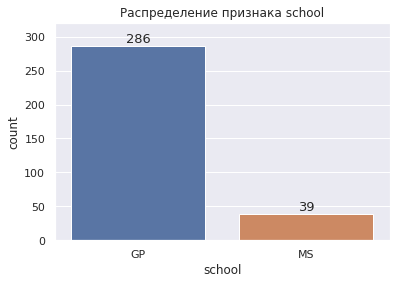

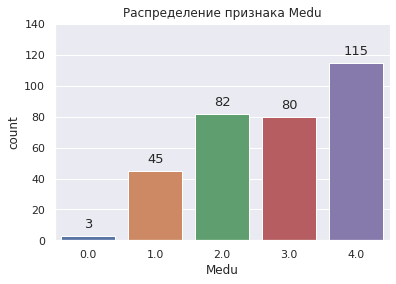

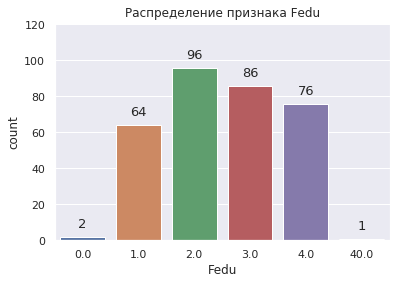

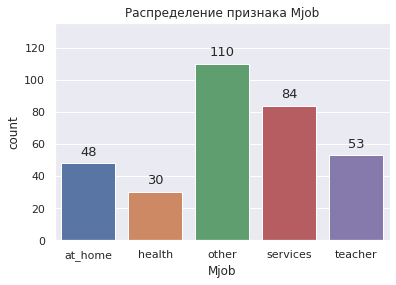

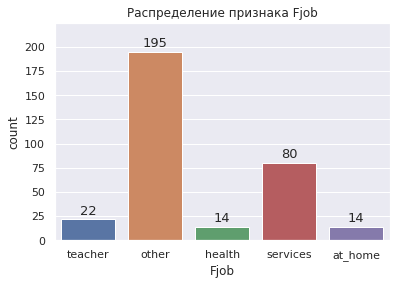

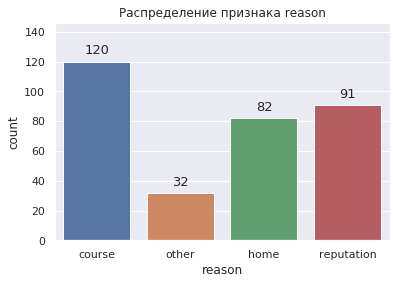

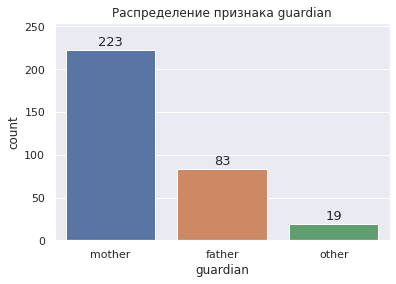

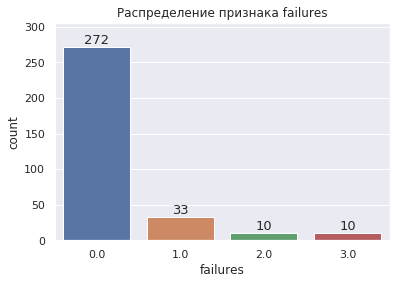

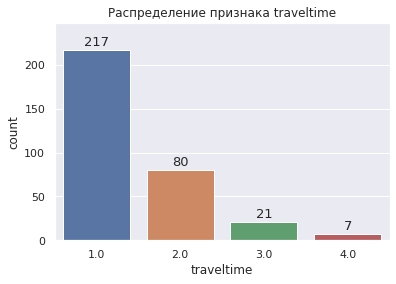

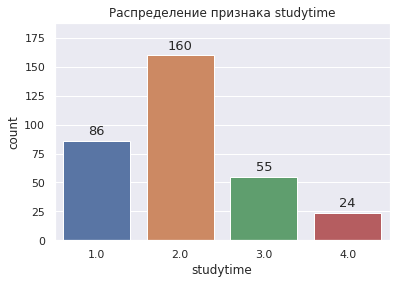

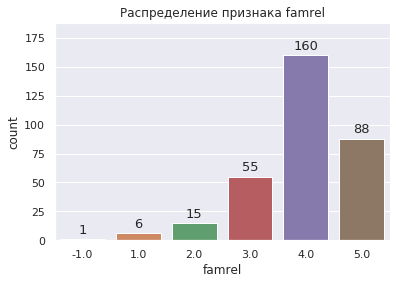

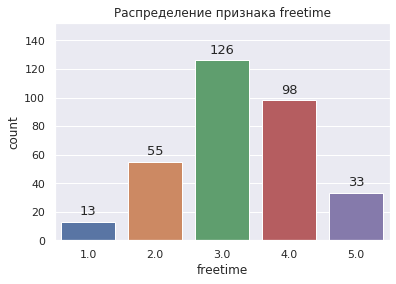

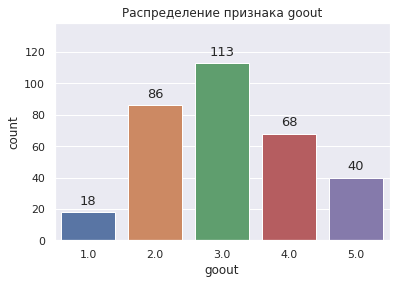

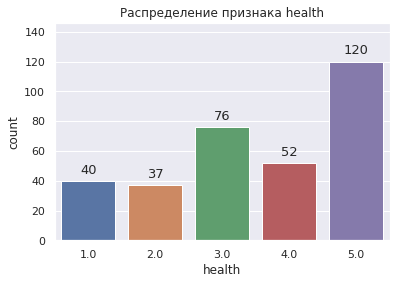

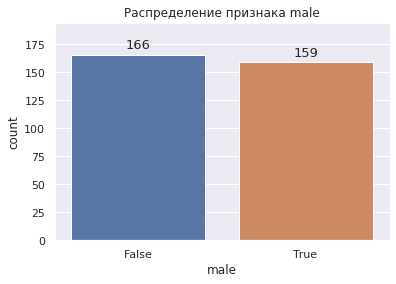

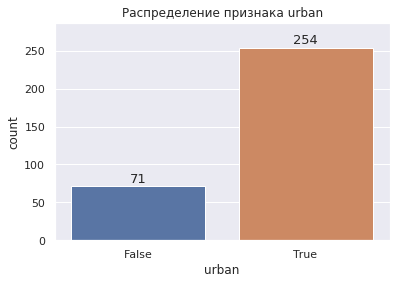

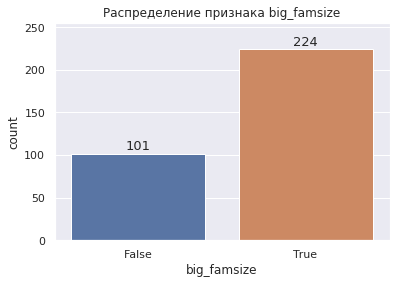

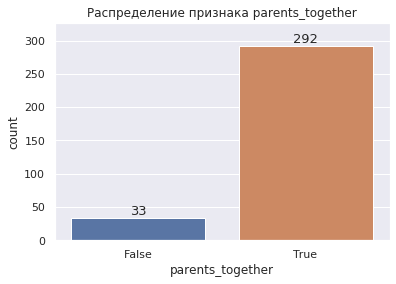

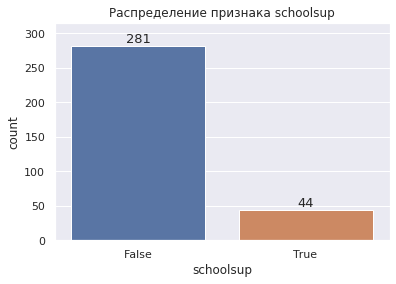

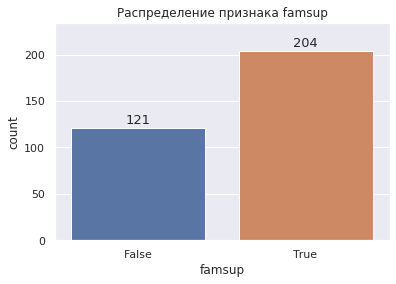

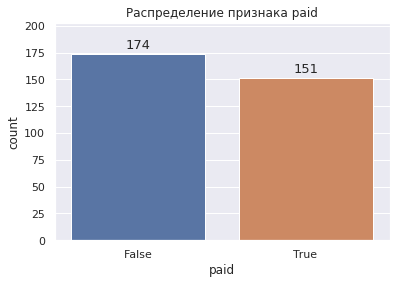

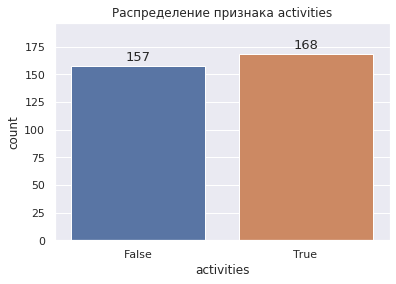

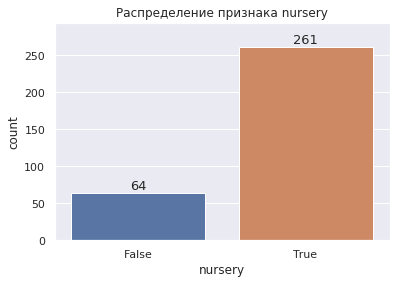

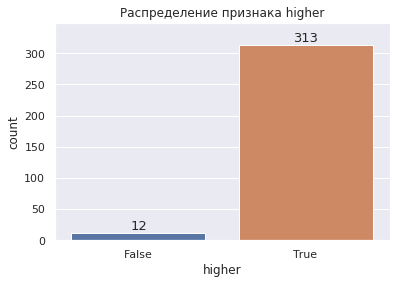

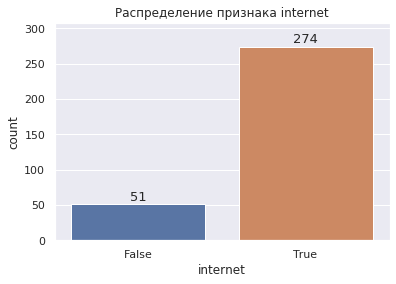

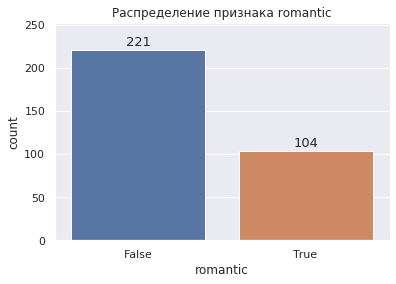

In [26]:
for col in categ_cols + bool_cols:
    show_distribution_of_categorial_variable(students, col)

Исправим ошибки в данных

In [27]:
students["Fedu"].replace({40: 4}, inplace=True)
students["famrel"].replace({-1: 1}, inplace=True)

## Корреляционный анализ

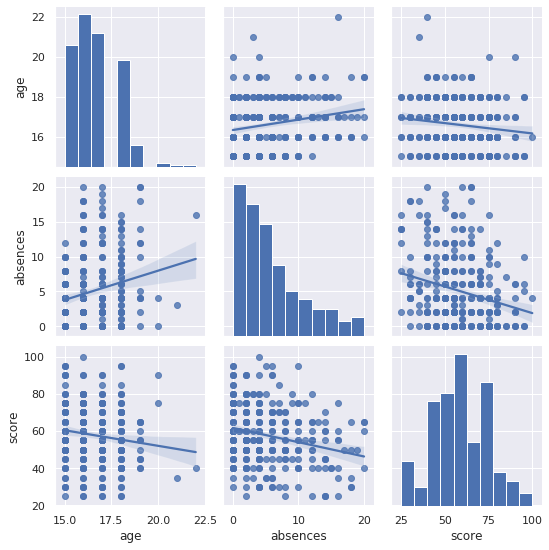

In [28]:
sns.pairplot(students[quant_cols], kind="reg")

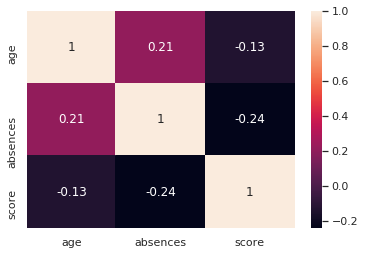

In [29]:
sns.heatmap(students[quant_cols].corr(), annot=True);

Судя по графикам, при увеличении возраста и при увеличении количества пропущенных занятий, оценка по математики снижается

## Анализ категориальных признаков

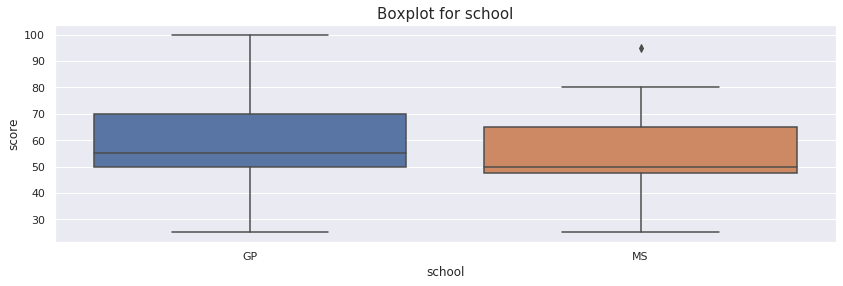

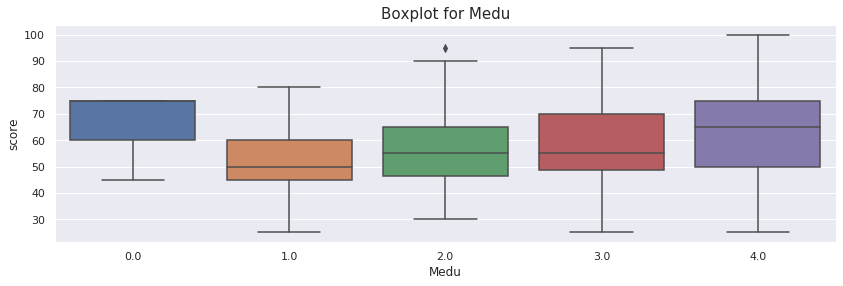

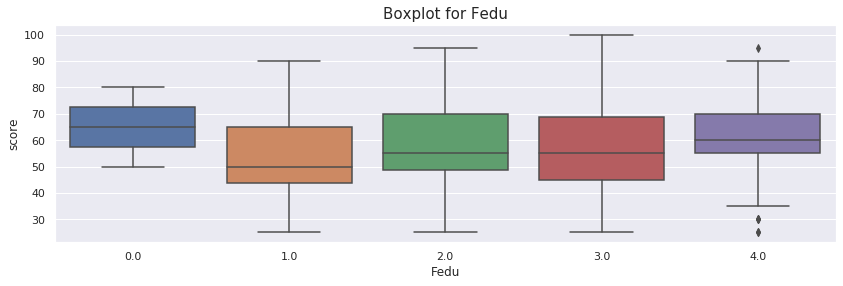

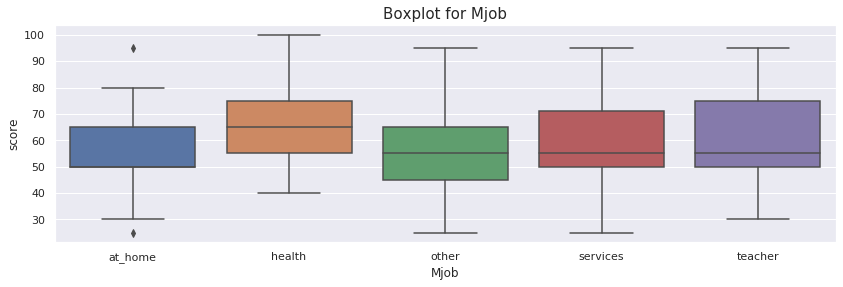

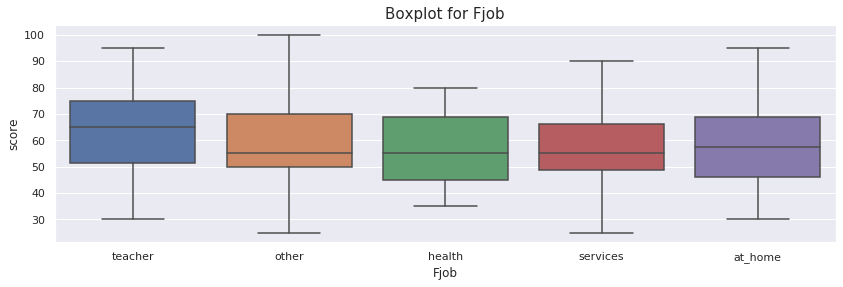

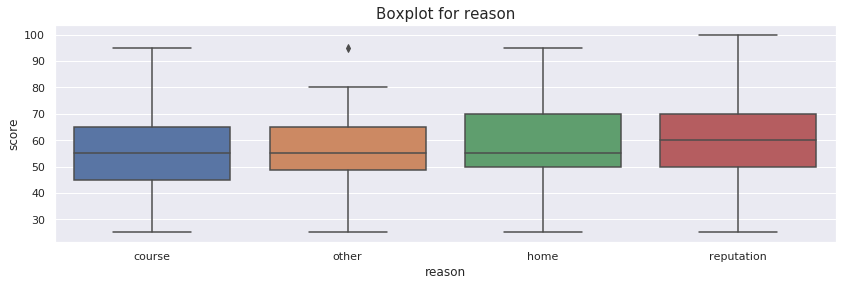

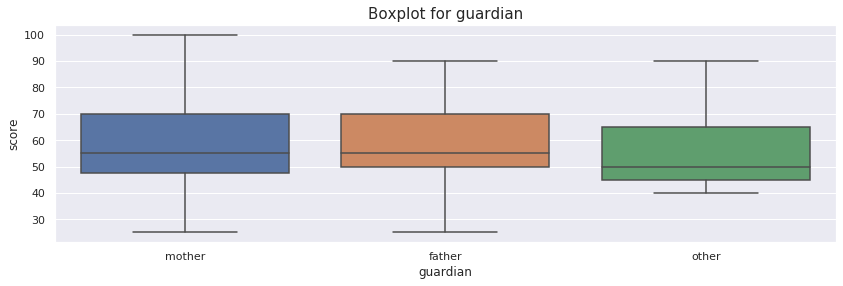

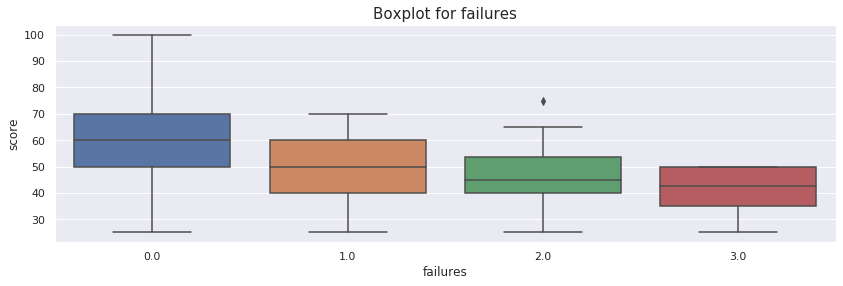

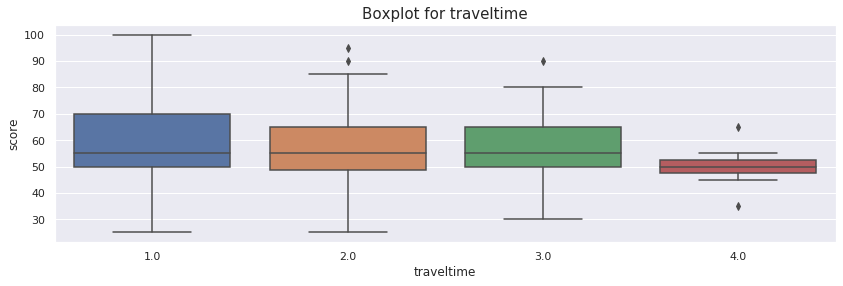

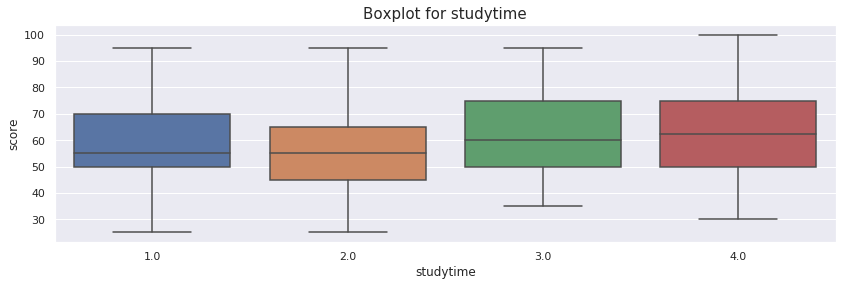

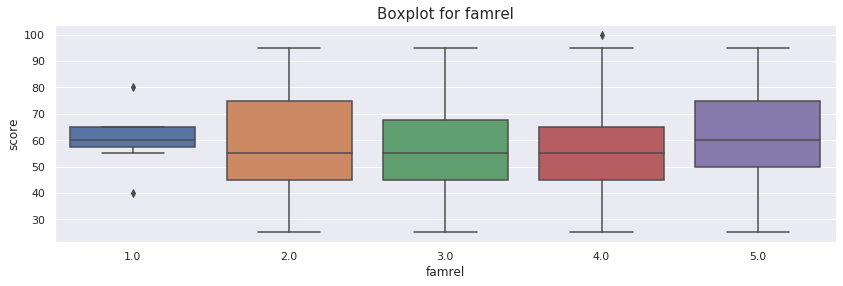

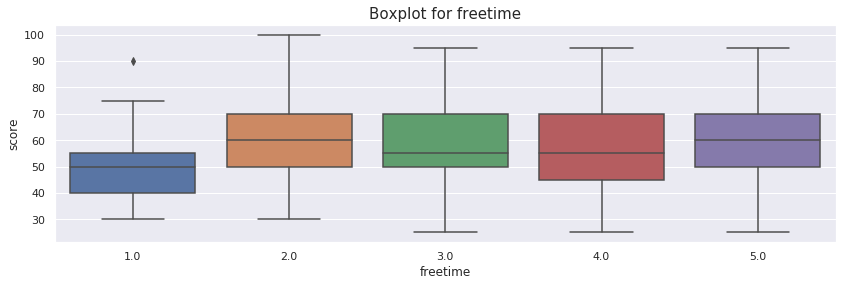

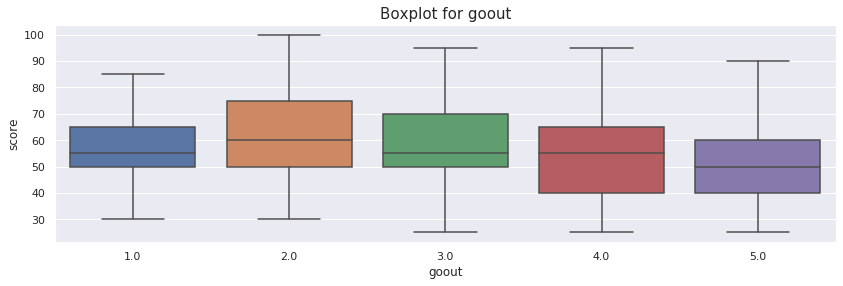

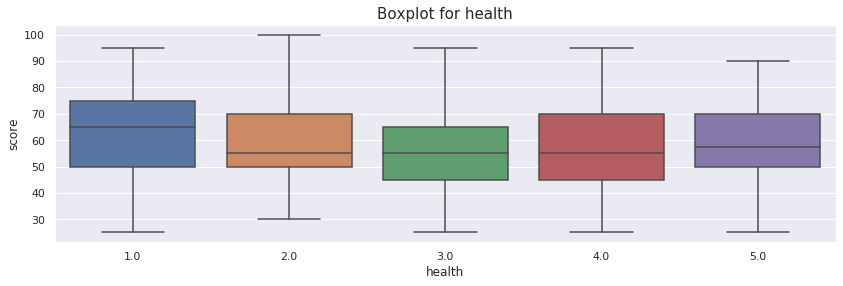

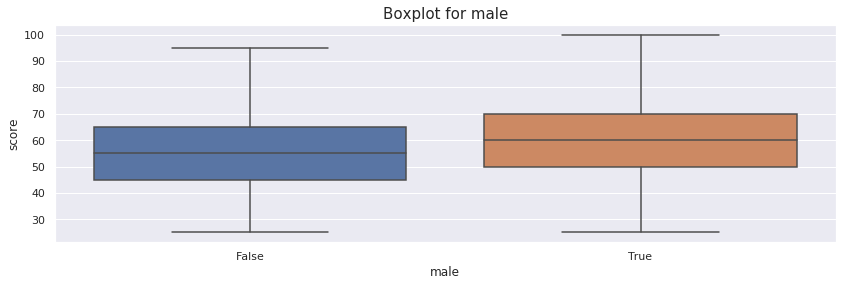

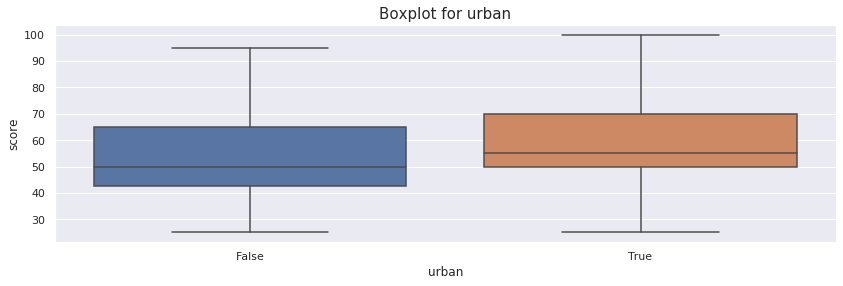

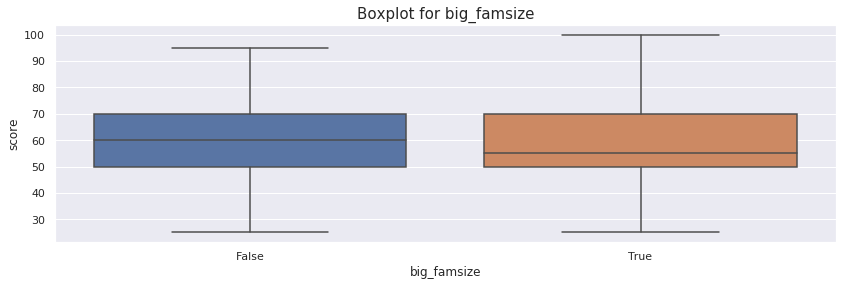

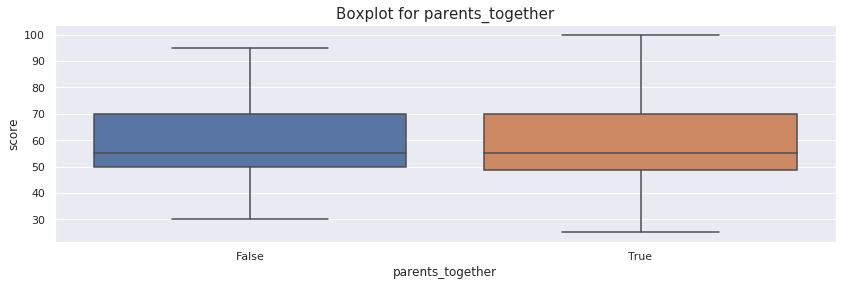

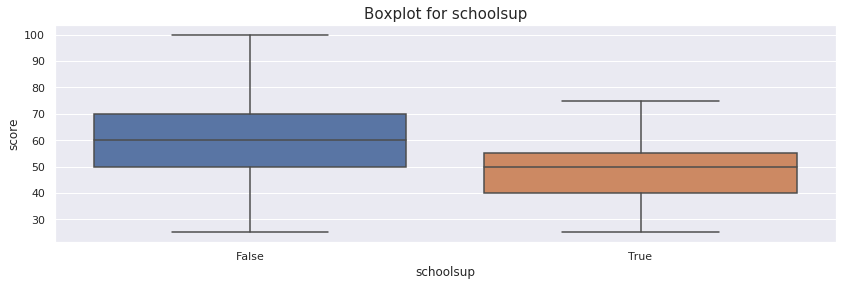

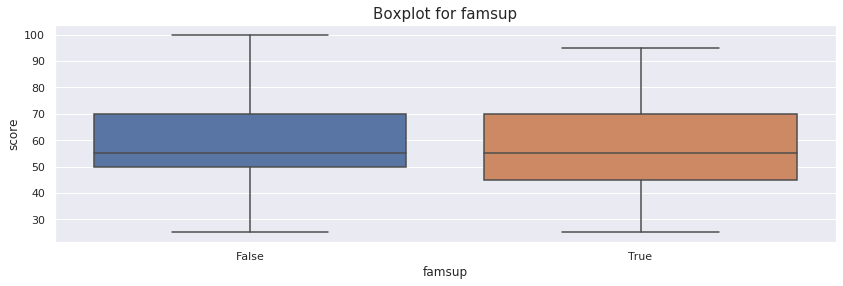

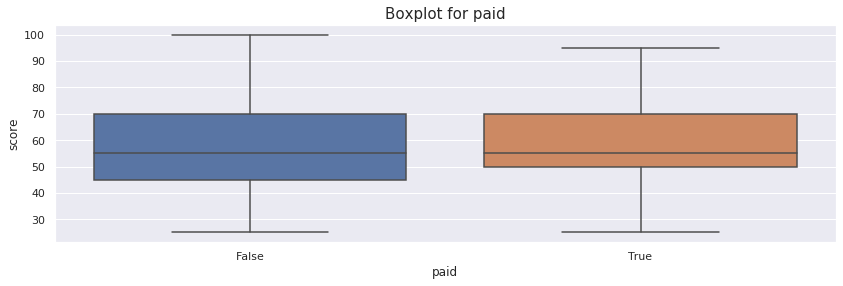

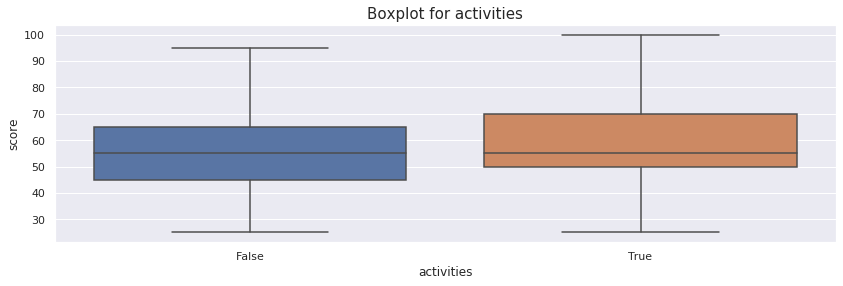

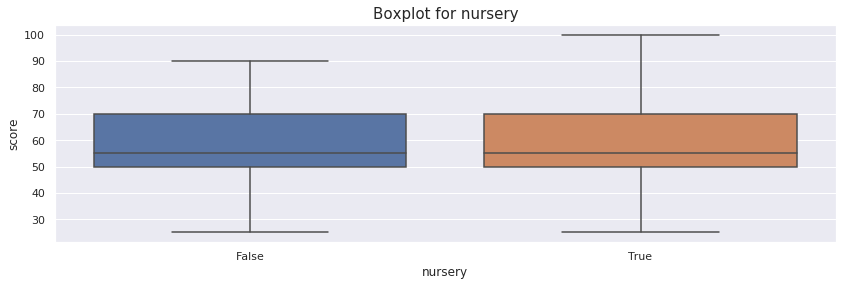

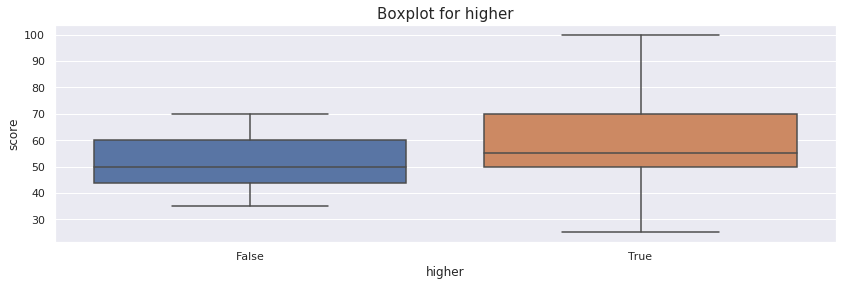

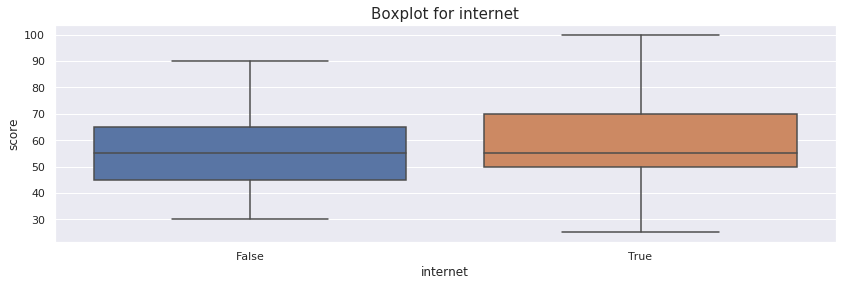

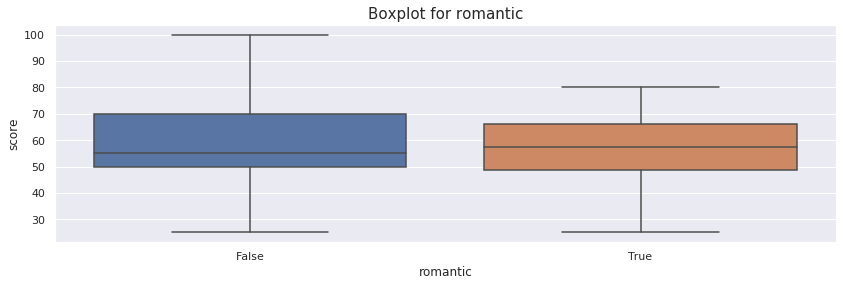

In [30]:
for col in categ_cols + bool_cols:
    show_boxplot_with_score(students, col)

Судя по графикам, некоторые признаки никак не влияют на показатель *score*, например, посещение детского сада, проживание родителей вместе и размер семьи. Для того, что нам убедиться в догадках и найти статистически значимые различия можно использовать тест Стьюдента

In [31]:
for col in categ_cols + bool_cols:
    get_stat_dif(students, col)

Найдены статистически значимые различия для колонки Medu
Найдены статистически значимые различия для колонки Fedu
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки studytime
Найдены статистически значимые различия для колонки goout
Найдены статистически значимые различия для колонки male
Найдены статистически значимые различия для колонки urban
Найдены статистически значимые различия для колонки schoolsup


Как мы видим, серьёзно отличаются 9 категориальных признаков: Medu, Fedu, failures, Mjob, studytime, goout, male, urban и schoolsup. Оставим эти признаки в датасете для дальнейшего построения модели. Также оставим в датасете и численные признаки: age и absences

In [32]:
students_for_model = students[["age", "absences", "Medu", "Fedu", "failures", "Mjob",
                                            "studytime", "goout", "male", "urban", "schoolsup"]]
students_for_model.head()

,age,absences,Medu,Fedu,failures,Mjob,studytime,goout,male,urban,schoolsup
0,18,6.0,4.0,4.0,0.0,at_home,2.0,4.0,False,True,True
1,17,4.0,1.0,1.0,0.0,at_home,2.0,3.0,False,True,False
2,15,10.0,1.0,1.0,3.0,at_home,2.0,2.0,False,True,True
3,15,2.0,4.0,2.0,0.0,health,3.0,2.0,False,True,False
4,16,4.0,3.0,3.0,0.0,other,2.0,2.0,False,True,False


## Выводы

- В данных достаточно мало пустых значений, около 5%, практически все столбцы имеют пропуски, но в небольшом количестве.
- Выбросы найдены только в столбце absences, что позволяет сделать вывод о том, что данные достаточно чистые.
- Отрицательная корреляция параметра age и score может говорить о том, что с возрастом ученики получают худшие результаты экзамена.
- Отрицательная корреляция параметра absences и score может говорить о том, что чем больше ученики пропускают занятий, тем хуже результат экзамена.
- Самые важные параметры, которые предлагается использовать в дальнейшем для построения модели, это age, absences, Medu, Fedu, failures, Mjob, studytime, goout, male, urban и schoolsup.